In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as plt


In [2]:
a2users = pd.read_csv(r'C:\Users\elisa\Downloads\a2usersOK.csv',sep=';',low_memory=False)

In [3]:
exclude = a2users["Last_Online_Subscription"] == "AcomeA" #get rid of those customers coming from AcomeA NOT Gimme5
a2users = a2users[~exclude].copy() #~operator get the complementary

a2users["DateTime_Subscription"] = pd.to_datetime(a2users["DateTime_Subscription"]) #make the date in time format

In [4]:
conda install -c conda-forge lifelines

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
from lifelines import KaplanMeierFitter #package for Survival Analysis

In [6]:
a2users.columns

Index(['ID_User', 'ID_Promotion', 'ID_Promo_Code', 'Age', 'Sex',
       'Email_Domain', 'Flag_User_Disabled', 'Date_Last_Access',
       'Registration_Case', 'Description_Registration_Case',
       'Registration_Step', 'Registration_SubStep',
       'Description_Registration_Step', 'User_Status', 'has_ID_Facebook',
       'has_ID_GPlus', 'User_Class', 'Flag_Test_User', 'Residence_Province',
       'Favourite_Contract_Class', 'Activation_Payment_Method',
       'Payment_Method', 'Subscription_Bonus', 'DateTime_First_Login',
       'First_Login_Type', 'First_Login_Asset', 'DateTime_Last_Login',
       'Last_Login_Type', 'Last_Login_Asset', 'DateTime_Subscription',
       'DateTime_First_Conclusion', 'DateTime_Last_Conclusion',
       'DateTime_First_Investment', 'Last_Online_Subscription',
       'All_Online_Subscriptions', 'User_Status_Detail', 'subscr_year',
       'subscr_month', 'infYear', 'infGender', 'ageAtSubscription', 'ageBand'],
      dtype='object')

In [7]:
subset = a2users["DateTime_Subscription"].apply(lambda x: x>datetime(2017,10,1))
a2users = a2users[subset].copy()
del subset #get rid of all the info about subscriptions before that time

In [8]:
a2users["User_Status_Detail"].value_counts() #for each status check they are not the same and also get rid of 
#the 'Solo su AcomeA-Online' since we already filter by AcomeA before.
#User Test is NOISE: eliminated
#User canceled gives instead info: they canceled before termining the subscription process.
#Here we are performing another kind of analysis and we get rid also of Canceled User but it actually is informative

2 - Sottoscrizione Iniziata    44834
1 - Mail Validata              17314
10 - Concluso                  15636
5 - Residenza OK                9036
0 - E-Mail non verificata       8733
8 - Antiriciclaggio OK          7068
4 - Dati Personali OK           2854
3 - Codice Fiscale OK           2658
Utente Cancellato               1786
6 - Documento ID OK             1660
9 - Fondo Scelto                1230
7 - Documenti Firmati            386
Utente Test                      207
A - Solo su AcomeA-Online         25
Name: User_Status_Detail, dtype: int64

In [9]:
a2users.loc[pd.isna(a2users["subscr_year"]),"subscr_year"] = 0             #subscript. year = 0 must be canceled
a2users["subscr_year"] = a2users["subscr_year"].astype(int)         #set to integers these years

In [10]:
# move into make_dataset.py or into the data extraction queries
a2users = a2users[a2users["User_Status_Detail"]!="A - Solo su AcomeA-Online"].copy()

a2users["stage"] = -1 
#users are classified in stage = -1 by default, but if they have User_Status_Detail as follow they are reclassified

a2users.loc[a2users["User_Status_Detail"]=="0 - E-Mail non verificata","stage"] = 0 
#set =0 the values of the User_Status_Detail col equal to "0 - E-Mail non verificata" and add column "stage"
a2users.loc[a2users["User_Status_Detail"]=="1 - Mail Validata","stage"] = 1
a2users.loc[a2users["User_Status_Detail"]=="2 - Sottoscrizione Iniziata","stage"] = 2
a2users.loc[a2users["User_Status_Detail"]=="3 - Codice Fiscale OK","stage"] = 3
a2users.loc[a2users["User_Status_Detail"]=="4 - Dati Personali OK","stage"] = 4
a2users.loc[a2users["User_Status_Detail"]=="5 - Residenza OK","stage"] = 5
a2users.loc[a2users["User_Status_Detail"]=="6 - Documento ID OK","stage"] = 6
a2users.loc[a2users["User_Status_Detail"]=="7 - Documenti Firmati","stage"] = 7
a2users.loc[a2users["User_Status_Detail"]=="8 - Antiriciclaggio OK","stage"] = 8
a2users.loc[a2users["User_Status_Detail"]=="9 - Fondo Scelto","stage"] = 9
a2users.loc[a2users["User_Status_Detail"]=="10 - Concluso","stage"] = 10

a2users = a2users[a2users["stage"]>-1].copy() #we get rid of those that are stacked at stage, but actually we already done this by
# get rid of the User test and Canceled User

In [11]:
a2users["inf_loginType"] = "Altri" #create also another column called "inf_loginType" and set its default value equal to "Altri"

#Then those who have these characteristics will change the default value for column "inf_loginType"
fb = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==0)
a2users.loc[fb,"inf_loginType"] = "Facebook"

gp = (a2users["has_ID_Facebook"]==0) & (a2users["has_ID_GPlus"]==1)
a2users.loc[gp,"inf_loginType"] = "Google"

multi = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==1)
a2users.loc[multi,"inf_loginType"] = "Multi"

In [12]:
funnelDataY = a2users.groupby(["stage","User_Status_Detail","subscr_year"])["ID_User"].count().reset_index()
#group by these columns and count the userid for each
funnelDataY
#so for each stage and aech of the three considered years we count the user_id in order to see the funnel

,stage,User_Status_Detail,subscr_year,ID_User
0,0,0 - E-Mail non verificata,2017,1258
1,0,0 - E-Mail non verificata,2018,4210
2,0,0 - E-Mail non verificata,2019,3265
3,1,1 - Mail Validata,2017,2366
4,1,1 - Mail Validata,2018,8078
5,1,1 - Mail Validata,2019,6870
6,2,2 - Sottoscrizione Iniziata,2017,4217
7,2,2 - Sottoscrizione Iniziata,2018,25042
8,2,2 - Sottoscrizione Iniziata,2019,15575
9,3,3 - Codice Fiscale OK,2017,258


In [13]:
funnelStageYear = pd.pivot_table(funnelDataY, index=["stage","User_Status_Detail"],columns="subscr_year",values="ID_User")
#we alsp run a pivot to understand
funnelStageYear

,subscr_year,2017,2018,2019
stage,User_Status_Detail,,,
0,0 - E-Mail non verificata,1258,4210,3265
1,1 - Mail Validata,2366,8078,6870
2,2 - Sottoscrizione Iniziata,4217,25042,15575
3,3 - Codice Fiscale OK,258,1244,1156
4,4 - Dati Personali OK,205,1459,1190
5,5 - Residenza OK,565,4299,4172
6,6 - Documento ID OK,190,971,499
7,7 - Documenti Firmati,89,187,110
8,8 - Antiriciclaggio OK,394,3410,3264


In [14]:
a2users.info()
#It gives us information about the data types and the number of rows in each column that has null values. 
#It’s very important for us to remove the rows with a null value for some of the methods in survival analysis.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 111409 entries, 0 to 217704
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ID_User                        111409 non-null  int64         
 1   ID_Promotion                   111409 non-null  int64         
 2   ID_Promo_Code                  21692 non-null   float64       
 3   Age                            111409 non-null  float64       
 4   Sex                            111409 non-null  int64         
 5   Email_Domain                   111405 non-null  object        
 6   Flag_User_Disabled             111409 non-null  float64       
 7   Date_Last_Access               111185 non-null  object        
 8   Registration_Case              111409 non-null  float64       
 9   Description_Registration_Case  111409 non-null  object        
 10  Registration_Step              111409 non-null  object        
 11  

In [15]:
a2users.describe()
#It gives us some statistical information like the total number of rows, mean, standard deviation, minimum value,
#25th percentile, 50th percentile, 75th percentile, and maximum value for each column in our dataset.

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Flag_User_Disabled,Registration_Case,Registration_SubStep,has_ID_Facebook,has_ID_GPlus,Flag_Test_User,Subscription_Bonus,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,stage
count,111409.000000,111409.000000,21692.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.0,21690.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.000000,111409.000000
mean,124437.391423,5.701460,339590.104278,11.671768,2.366505,0.078387,0.367843,1.127698,0.185784,0.126929,0.0,8.785154,2018.284600,5.797682,761.492312,2.366505,12.371281,3.663869
std,44670.310908,11.935534,135577.366582,17.065812,0.886618,0.268781,0.487515,1.667599,0.388934,0.332895,0.0,2.163163,0.633859,3.378082,965.474815,0.886618,17.157986,3.269410
min,1.000000,0.000000,40056.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.000000,2017.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,97306.000000,0.000000,400810.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,2018.000000,3.000000,0.000000,1.000000,0.000000,2.000000
50%,126143.000000,0.000000,401000.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,2018.000000,6.000000,0.000000,3.000000,0.000000,2.000000
75%,154939.000000,0.000000,401000.000000,25.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.0,10.000000,2019.000000,8.000000,1983.000000,3.000000,26.000000,5.000000
max,217705.000000,39.000000,401210.000000,91.000000,3.000000,1.000000,3.000000,4.000000,1.000000,1.000000,0.0,15.000000,2019.000000,12.000000,2015.000000,3.000000,97.000000,10.000000


## Survival Analysis

In [16]:
#create an object from KaplanMeierFitter
kmf = KaplanMeierFitter()

In [17]:
# if User_status_detail = 10 -> new column: concluded = 1
# otherwise: concluded = 0

a2users.loc[a2users.User_Status_Detail == '10 - Concluso', 'concluded'] = 1
a2users.loc[a2users.User_Status_Detail != '10 - Concluso', 'concluded'] = 0

In [18]:
a2users.head()

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType,concluded
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,10 - Concluso,2019,3,1975.0,1,43,40-45,10,Multi,1.0
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,10 - Concluso,2019,3,1990.0,1,28,25-30,10,Altri,1.0
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,10 - Concluso,2018,11,1987.0,1,31,30-35,10,Altri,1.0
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,10 - Concluso,2018,2,1982.0,1,35,35-40,10,Altri,1.0
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,10 - Concluso,2018,5,1957.0,1,60,60-65,10,Altri,1.0


In [19]:
import datetime
import time

In [20]:
todaysDate = datetime.date.today() #variable for today

In [21]:
a2users['DateTime_First_Conclusion']= pd.to_datetime(a2users['DateTime_First_Conclusion'])
type(a2users['DateTime_First_Conclusion'])

pandas.core.series.Series

In [22]:
##################### How to build the column survival times? ##################################################################

# when was the person observed in our experiment -> use the today's variable

a2users['NewDateTime_Subscription'] = a2users['DateTime_Subscription'].dt.strftime('%d/%m/%Y')
a2users['NewDateTime_First_Conclusion'] = a2users['DateTime_First_Conclusion'].dt.strftime('%d/%m/%Y')

a2users['NewDateTime_First_Conclusion']= pd.to_datetime(a2users['NewDateTime_First_Conclusion'])
a2users['NewDateTime_Subscription']= pd.to_datetime(a2users['NewDateTime_Subscription'])
to_now= pd.to_datetime(todaysDate)

In [23]:
a2users['time'] = to_now-(a2users['NewDateTime_Subscription']) # time passed between now and the date of subscription
#how long do they take to conclude subscription?

In [24]:
a2users['time']= a2users['time']/np.timedelta64(1, 'M') #expree is in months not days

In [25]:
kmf.fit(a2users['time'], event_observed= a2users['concluded'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 111409 total observations, 95773 right-censored observations>

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.impute import SimpleImputer
from lifelines import KaplanMeierFitter, CoxPHFitter



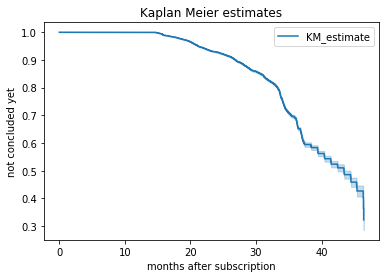

In [27]:
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")
plt.show()
#as months pass people start concluding: it seems that people actually start concluding the subscription after 1 year and after 
# 3 years the 50% has concluded
# Of course as we had seen from the funnel there is a percentage of people that never conclude


In [28]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.000000,0,0,0,111409,111409
14.587569,38,2,36,0,111409
14.620423,294,18,276,0,111371
14.653278,210,24,186,0,111077
14.686133,227,31,196,0,110867
...,...,...,...,...,...
45.372595,53,6,47,0,343
45.405450,51,9,42,0,290
46.358241,83,14,69,0,239


In [29]:
print("Avg time to the conclusion:",kmf.median_survival_time_)


Avg time to the conclusion: 43.43415675886568


In [30]:
print(kmf.survival_function_)

           KM_estimate
timeline              
0.000000      1.000000
14.587569     0.999982
14.620423     0.999820
14.653278     0.999604
14.686133     0.999325
...                ...
45.372595     0.440389
45.405450     0.426721
46.358241     0.401725
46.391096     0.363098
46.423951     0.322185

[707 rows x 1 columns]


## By promotion code groups survival analysis

In [31]:
prom5 = a2users[a2users['Subscription_Bonus']== 5.0]
prom10 = a2users[a2users['Subscription_Bonus']== 10.0]
prom15 = a2users[a2users['Subscription_Bonus']== 15.0]

In [32]:
kmf.fit(prom5['time'], event_observed = prom5['concluded'], label = 'with 5 Euros Bonus')


<lifelines.KaplanMeierFitter:"with 5 Euros Bonus", fitted with 5305 total observations, 3800 right-censored observations>

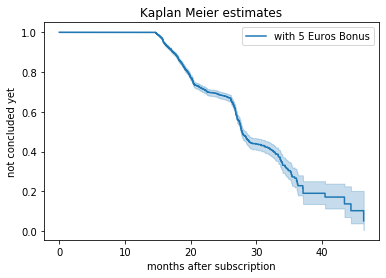

In [33]:
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")
plt.show()

Among those having received the 5 euros bonus we can see that, at the end, they almost all conclude the subscription process even if after about 4 years.

In [34]:
kmf.fit(prom10['time'], event_observed = prom10['concluded'], label = 'with 10 Euros Bonus')


<lifelines.KaplanMeierFitter:"with 10 Euros Bonus", fitted with 16350 total observations, 13723 right-censored observations>

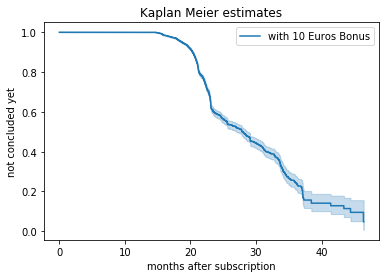

In [35]:
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")
plt.show()

For what concern the ones having received the 10 euros bonus we can see that there is a sharp increase of the conclusions within the second year after the subscritpion starts

In [36]:
kmf.fit(prom15['time'], event_observed = prom15['concluded'], label = 'with 15 Euros Bonus')


<lifelines.KaplanMeierFitter:"with 15 Euros Bonus", fitted with 35 total observations, 14 right-censored observations>

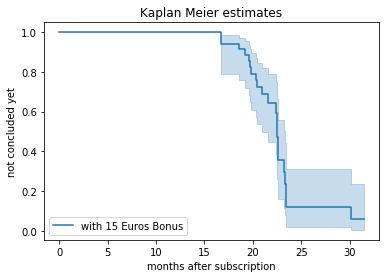

In [37]:
kmf.plot()
plt.title("Kaplan Meier estimates")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")
plt.show()

 the variance is high since the ones receiving the 15 euros bonus are a small portion of the whole and so the analysis is not 
 statistically significant

Text(0, 0.5, 'not concluded yet')

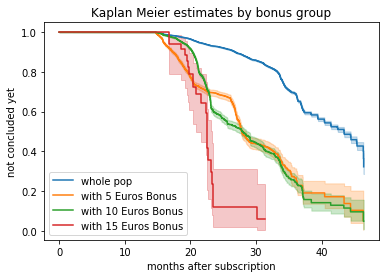

In [38]:
ax = plt.subplot(111)
kmf.fit(a2users['time'], event_observed = a2users['concluded'], label = 'whole pop')
kmf.plot(ax = ax)
kmf.fit(prom5['time'], event_observed = prom5['concluded'], label = 'with 5 Euros Bonus')
kmf.plot(ax = ax)
kmf.fit(prom10['time'], event_observed = prom10['concluded'], label = 'with 10 Euros Bonus')
kmf.plot(ax = ax)
kmf.fit(prom15['time'], event_observed = prom15['concluded'], label = 'with 15 Euros Bonus')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by bonus group")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet") 
#we can clearly see that the promotion codes diminuish the time needed to people to conclude the subscription

In [39]:
a2users.columns


Index(['ID_User', 'ID_Promotion', 'ID_Promo_Code', 'Age', 'Sex',
       'Email_Domain', 'Flag_User_Disabled', 'Date_Last_Access',
       'Registration_Case', 'Description_Registration_Case',
       'Registration_Step', 'Registration_SubStep',
       'Description_Registration_Step', 'User_Status', 'has_ID_Facebook',
       'has_ID_GPlus', 'User_Class', 'Flag_Test_User', 'Residence_Province',
       'Favourite_Contract_Class', 'Activation_Payment_Method',
       'Payment_Method', 'Subscription_Bonus', 'DateTime_First_Login',
       'First_Login_Type', 'First_Login_Asset', 'DateTime_Last_Login',
       'Last_Login_Type', 'Last_Login_Asset', 'DateTime_Subscription',
       'DateTime_First_Conclusion', 'DateTime_Last_Conclusion',
       'DateTime_First_Investment', 'Last_Online_Subscription',
       'All_Online_Subscriptions', 'User_Status_Detail', 'subscr_year',
       'subscr_month', 'infYear', 'infGender', 'ageAtSubscription', 'ageBand',
       'stage', 'inf_loginType', 'concluded', 'New

# Survival analysis for Login type

In [40]:
#create a subset for each info login type
fb = a2users[a2users['inf_loginType'] == 'Facebook']
google = a2users[a2users['inf_loginType'] == 'Google']
multi = a2users[a2users['inf_loginType'] == 'Multi']
altri = a2users[a2users['inf_loginType'] == 'Altri']

Text(0, 0.5, 'not concluded yet')

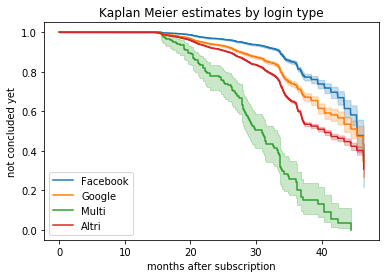

In [41]:
ax = plt.subplot(111)
kmf.fit(a2users['time'], event_observed = a2users['concluded'], label = 'whole pop')
kmf.fit(fb['time'], event_observed = fb['concluded'], label = 'Facebook')
kmf.plot(ax = ax)
kmf.fit(google['time'], event_observed = google['concluded'], label = 'Google')
kmf.plot(ax = ax)
kmf.fit(multi['time'], event_observed = multi['concluded'], label = 'Multi')
kmf.plot(ax = ax)
kmf.fit(altri['time'], event_observed = altri['concluded'], label = 'Altri')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by login type")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")

It seems that those using both Google and Facebook to login are faster in cocnluding the subscription process

# Survival Analysis for Payment Method

In [42]:
a2users['Payment_Method'].unique()

array(['RD', 'BO', nan], dtype=object)

In [43]:
#create a subset for each payment method

RD = a2users[a2users['Payment_Method'] == 'RD']
BO = a2users[a2users['Payment_Method'] == 'BO']

Text(0, 0.5, 'not concluded yet')

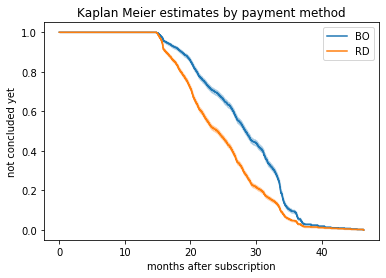

In [44]:
ax = plt.subplot(111)
kmf.fit(a2users['time'], event_observed = a2users['concluded'], label = 'whole pop')
kmf.fit(BO['time'], event_observed = BO['concluded'], label = 'BO')
kmf.plot(ax = ax)
kmf.fit(RD['time'], event_observed = RD['concluded'], label = 'RD')
kmf.plot(ax = ax)
plt.title("Kaplan Meier estimates by payment method")
plt.xlabel("months after subscription")
plt.ylabel("not concluded yet")

In [45]:
a2users['SB'] = a2users['Subscription_Bonus']
a2users['PM'] = a2users['Payment_Method']
NA = pd.isna(a2users['Subscription_Bonus'])
NA1 = pd.isna(a2users['Payment_Method'])
a2users.loc[NA,'SB'] = 0
a2users.loc[NA1, 'PM'] = 0
a2users.head()

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,ageAtSubscription,ageBand,stage,inf_loginType,concluded,NewDateTime_Subscription,NewDateTime_First_Conclusion,time,SB,PM
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,43,40-45,10,Multi,1.0,2019-03-12,2019-08-22,20.435738,10.0,RD
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,28,25-30,10,Altri,1.0,2019-03-30,2019-04-01,19.844350,5.0,RD
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,31,30-35,10,Altri,1.0,2018-11-19,2018-12-20,24.148340,0.0,RD
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,35,35-40,10,Altri,1.0,2018-02-14,2018-02-16,33.281998,0.0,RD
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,60,60-65,10,Altri,1.0,2018-05-13,2018-05-14,30.390768,0.0,RD


In [46]:

a2users.loc[~NA,'SB'] = 1

a2users[['SB', 'PM']]

,SB,PM
0,1.0,RD
2,1.0,RD
3,0.0,RD
5,0.0,RD
6,0.0,RD
...,...,...
217687,0.0,0
217691,0.0,0
217694,0.0,0
217695,0.0,0


In [47]:
hazard = a2users[['SB', 'Age','inf_loginType','PM','time','concluded']]
hazard.reset_index()

,index,SB,Age,inf_loginType,PM,time,concluded
0,0,1.0,44.0,Multi,RD,20.435738,1.0
1,2,1.0,28.0,Altri,RD,19.844350,1.0
2,3,0.0,32.0,Altri,RD,24.148340,1.0
3,5,0.0,37.0,Altri,RD,33.281998,1.0
4,6,0.0,62.0,Altri,RD,30.390768,1.0
...,...,...,...,...,...,...,...
111404,217687,0.0,0.0,Altri,0,34.563338,0.0
111405,217691,0.0,0.0,Altri,0,31.672108,0.0
111406,217694,0.0,0.0,Altri,0,39.393006,0.0
111407,217695,0.0,0.0,Altri,0,37.421713,0.0


In [48]:
hazard['inf_loginType'].unique()

array(['Multi', 'Altri', 'Google', 'Facebook'], dtype=object)

In [53]:
hazard_dummies = pd.get_dummies(hazard, columns=['inf_loginType', 'PM'])
hazard_dummies = hazard_dummies[['SB', 'time', 'concluded', 'inf_loginType_Altri', 'inf_loginType_Facebook', 'inf_loginType_Google', 'inf_loginType_Multi', 'PM_BO', 'PM_RD' ]]

In [55]:
import lifelines
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(hazard_dummies, duration_col='time', event_col='concluded', show_progress=False)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 111409 total observations, 95773 right-censored observations>
             duration col = 'time'
                event col = 'concluded'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 111409
number of events observed = 15636
   partial log-likelihood = -149772.67
         time fit was run = 2020-11-23 17:58:08 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
SB                       0.85       2.34       0.02             0.82             0.88                 2.26                 2.41
inf_loginType_Altri      0.14       1.15       0.02             0.11             0.17                 1.11                 1.18
inf_loginType_Facebook  -0.20       0.82       0.02            -0.23            -0.16                 0.79                 0.85
inf_loginType_Google    -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
inf_loginType_Multi      0.11       1.12       0.09            -0.07             0.29                 0.93                 1.34
PM_BO                    2.28       9.76       0.02             2.24             2.31                 9.41                10.12
PM_RD                    2.58      13.26       0.02             2.55             2.62                12.83                13.70

                            z      p   -log2(p)
covariate                                      
SB                      51.16 <0.005        inf
inf_loginType_Altri      8.41 <0.005      54.50
inf_loginType_Facebook -10.25 <0.005      79.52
inf_loginType_Google    -0.05   0.96       0.06
inf_loginType_Multi      1.21   0.23       2.14
PM_BO                  122.86 <0.005        inf
PM_RD                  154.65 <0.005        inf
---
Concordance = 0.89
Partial AIC = 299559.35
log-likelihood ratio test = 32193.80 on 7 df
-log2(p) of ll-ratio test = inf

Looking at the exp(coef) we can say that the Subscription Bonus has a large positive effect on the conclusion:  a customer that receives a subscription bonus is 2.34 times as likely to conclude the subscription process.
Those providing also the Payment Method are very likely to conclude the subscription as we also had seen from the plot above, showing that within 4 years all those having inserted the payment method conclude the subscription.